# Generating the container 

In [42]:
import sys
print(sys.path)
import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass

from typing import List, Tuple

from ri_grad.components import *

['/usr/lib64/python311.zip', '/usr/lib64/python3.11', '/usr/lib64/python3.11/lib-dynload', '', '/home/vini/Documents/refindex_gradient/.venv/lib64/python3.11/site-packages', '/home/vini/Documents/refindex_gradient/.venv/lib/python3.11/site-packages']


In [43]:
# class Renderer:
#     def __init__(
#             self, 
#             geometry: Geometry, 
#             n_layers=15
#         ):
#         self.geometry = geometry
#         self.n_layers = n_layers

#         fig, ax = plt.subplots()
#         self.fig = fig
#         self.ax = ax
#         self._draw_aquarium()

#     def render_geometry(self):
#         plt.figure(self.fig.number)
#         ax = self.ax

#         # Draw the container (only bottom and left edges)
#         ax.plot([0, self.geometry.width], [0, 0], color='black')
#         ax.plot([0, 0], [0, self.geometry.height], color='black')

#     def _draw_aquarium(self):
#         plt.figure(self.fig.number) 
#         ax = self.ax

#         ax.set_xlim(0, self.container.width)
#         ax.set_ylim(0, self.container.height)
#         ax.set_aspect('equal')

#         # Remove top and right spines to resemble an aquarium
#         ax.spines['top'].set_visible(False)

#         # Keep only the bottom and left spines
#         ax.spines['left'].set_color('black')
#         ax.spines['right'].set_color('black')
#         ax.spines['bottom'].set_color('black')

#         # Remove ticks
#         ax.set_xticks([])

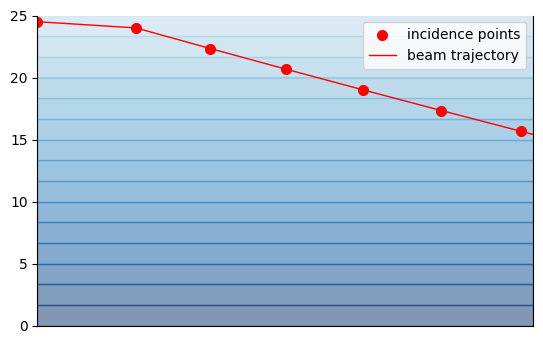

In [44]:
class Experiment:
    def __init__(self, container: Container, medium: Medium, beam: Beam):
        self.container = container
        self.medium = medium
        self.beam = beam

        fig, ax = plt.subplots()
        self.fig = fig
        self.ax = ax

        self._container_drawn = False

    def render_container(self):
        plt.figure(self.fig.number)
        ax = self.ax

        ax.set_xlim(0, self.container.width)
        ax.set_ylim(0, self.container.height)
        ax.set_aspect('equal')

        # Remove top and right spines to resemble an aquarium
        ax.spines['top'].set_visible(False)

        # Keep only the bottom and left spines
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')

        # Remove ticks
        ax.set_xticks([])

        self._container_drawn = True

    def render_medium(self):
        if not self._container_drawn:
            self.render_container()

        n_layers = self.medium.n_layers

        # Generate a linear light to dark blue gradient
        gradient = np.linspace(.3, 1, n_layers)[::-1]
        colors = plt.cm.Blues(gradient)

        # Draw the layers with the generated colors
        ax = self.ax
        for i in range(n_layers):
            layer_height = i * (self.container.height / n_layers)
            ax.fill_between(
                [0, self.container.width], 
                layer_height, 
                layer_height + (self.container.height / self.medium.n_layers), 
                color=colors[i], 
                alpha=0.5
            )    

    def render_beam(self, points: List[Tuple[float]]):
        if not self._container_drawn:
            self.render_medium()

        x, y = zip(*points) 
        ax = self.ax
        ax.scatter(x, y, color='red', linewidth=2, label='incidence points')
        ax.plot(x, y, color='red', linewidth=1, label='beam trajectory')
        ax.legend()
            
    """
    Receives a beam, an incidence point and an incidence angle.
    Calculates the refraction angles and points for each layer in the medium.
    """
    def _refraction(self, layer1: Layer, layer2: Layer, incidence_angle: float):        
        return np.arcsin((layer1.n / layer2.n) * np.sin(incidence_angle))
    
    def _refraction(self, n1: float, n2: float, incidence_angle: float):        
        return np.arcsin((n1 / n2) * np.sin(incidence_angle))
    
    """
    Calculates the point of incidence on the next layer. 
    """
    def _transmission(self, incidence_point: Tuple[float], refracted_angle: float):
        x_offset = self.medium.layer_thickness * np.tan(refracted_angle)
        return (incidence_point[0] + x_offset, incidence_point[1] - self.medium.layer_thickness)

    """
    The first refraction is a special case because the beam incides on the side wall of the container.
    Returns the point of incidence on the first layer and the incidence angle.
    """
    def _first_refraction(self, incidence_point: Tuple[float], incidence_angle: float):
        incidence_layer = self.medium.get_layer_from_y(incidence_point[1])
        y_offset = - incidence_point[1] % self.medium.layer_thickness

        refracted_angle = self._refraction(1, incidence_layer.n, incidence_angle) # angle of refraction with the container wall
        x_offset = y_offset / np.tan(refracted_angle)

        return ((incidence_point[0] + x_offset, incidence_point[1] - y_offset), (np.pi/2) - refracted_angle)

    """"
    Calculates the trajectory of the beam through the medium.
    Returns a list of points where the beam incides on each interface.
    """
    def beam_on(self):        
        points: List[Tuple[float]] = [] # list of points where the beam incides on each interface
        incidence_point: Tuple[float] = (0, self.beam.y_0) # initial point of incidence on the first layer
        points.append(incidence_point)

        # first refraction
        incidence_point, incidence_angle = self._first_refraction((0, self.beam.y_0), self.beam.angle)
        points.append(incidence_point)

        # remaining refractions
        incident_layer_index = self.medium.get_layer_index_from_y(incidence_point[1]) # index of the layer where the beam incides
        for i in range(incident_layer_index, self.medium.n_layers):
            layer = self.medium.layers[i]
            next_layer = self.medium.layers[i + 1] if i + 1 < self.medium.n_layers else None
            
            if next_layer is None: # last layer, no refraction
                break
            
            refracted_angle = self._refraction(layer.n, next_layer.n, incidence_angle)
            incidence_point = self._transmission(incidence_point, refracted_angle)
            points.append(incidence_point)

        return points
        

# experiment setup
container = Container(width=40, height=25)
medium = Medium(
    container,
    n_0=1.0, 
    n_f=1.5, 
    n_layers=15, 
    color='blue'
)
beam = Beam(wavelength=500e-9, y_0=24.5, angle=np.pi/50)

experiment = Experiment(container, medium, beam)
# experiment.render_beam()
points = experiment.beam_on()
experiment.render_beam(points)